In [6]:
from LABNET import Neuron, Net, Lab, Teacher,compare_rows

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


## Make Teacher object in LABNET, make functions below methods ##



make a network with the same number of inputs as outputs.  then, add lots of hidden layers that are the same size.  see which layers are getting the most gradient.  by sum of absolute error.  then graph all layers together, the compounding gradient as it accumulates backwards through time should cause the earliest layers to vanish or explode.  its always happening.  we are never exactly zero on that dial.  how to straighten out that line? this might actually be a sound theory.  

theory i guess:gradient explosion or collapse is a spectrum.  first, is it normally distributed? i think its distribution is a function of the architecture, the depth and the number of neurons.  depth contribution makes the most sense.  you need all the deep layers to compound to get either issue.  as you get deeper, the risk of catastrophic gradient deviation increases, or, if we think about training lots of neural networks, or just the same neural network multiple times, it likely does that in some distribution.  so, we should either see the earliest layers train first if the gradient explodes, or the latter layers to train first (if vanish or collapse).   however, it looks like it does one or the other and runs into a minima. a decent minima even.  what would that mean.  it means on the loss landscape there may be lots of really decent places for the weights to end up, even if it doesn't match the ideal (controlled generated) weights.  
WHAT IF SOME INDIVIDUAL VALUES INSIDE WEIGHT MATRICES (i need a name for not a neuron, but an individual weight inside that tensor)

so, look at lots of em, see if there is evidence for that.  

then, is there a way to cut the compounding during the backward pass.  what if each layer only takes into account the next weight layer, doesnt' back propagate all the way back.  does that make it so each neuron can pull its weight?

In [8]:
def plot_line_graph(numbers
                    ,window_size = 1
                    ,plot_size = (10,6)
                    ,x_range = (None, None)
                    ,y_range = (None, None)
                   ):
    
    if window_size <= 0 or window_size > len(numbers):
        raise ValueError("Invalid window size")
    
    running_sum = sum(numbers[:window_size])
    averages = [running_sum / window_size]

    for i in range(window_size, len(numbers)):
        running_sum += numbers[i] - numbers[i - window_size]
        averages.append(running_sum / window_size)
    
    
    
    x = range(1, len(averages) + 1)  
    y = averages  # y-axis values
    plt.figure(figsize=plot_size)
    plt.plot(x, y)  # Plotting the line graph
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if x_range[0] is not None and x_range[1] is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range[0] is not None and y_range[1] is not None:
        plt.ylim(y_range[0], y_range[1])
    
    plt.title('loss')

    plt.show() 

In [9]:
import torch


In [10]:


n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = Teacher(layer_sizes)
#initialize_weights_uniform(neural_network,0,1)


In [11]:
neural_network.generate_data(
    n
    ,'normal'
    , m =0.0
    , std=1.0
    , gen_lr = 0.01
    , gen_epochs = 1000
)

In [12]:
neural_network.model(neural_network.inputs[105])

tensor([-0.1950,  0.0270, -0.0651,  0.1466], grad_fn=<AddBackward0>)

In [73]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        #self.hidden_3 = nn.Linear(7,7)
        #self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        #x = self.relu(self.hidden_3(x))
        #x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [74]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
)


In [75]:
criterion = nn.MSELoss()
optimizer = optim.SGD(mymodel.parameters(), lr=0.05)

In [76]:
input_data = neural_network.inputs
output_data = neural_network.targets

In [77]:
# Training loop
#samples = n
samples = input_data.shape[0]
#print(samples)
num_epochs = 50

lab = Lab(mymodel,num_epochs,samples)
data = list(zip(input_data, output_data))

losses = []

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = mymodel(inputs)
        
        loss = criterion(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lab.record(mymodel,epoch,samples,sample)
        #print or store loss if you wanna
        losses.append(loss.item())

        
        sample += 1
 


In [78]:
#this will only work if the networks have the same architecture
test_list = list(zip([row for row in neural_network.model.parameters() if len(row.shape) > 1],
                     [row for row in mymodel.parameters() if len(row.shape) > 1]))

for i in test_list:
    #this first line will print out the row similarity matrix.
    #print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[0])
    print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[1])

8.142014
8.633067
4.866839


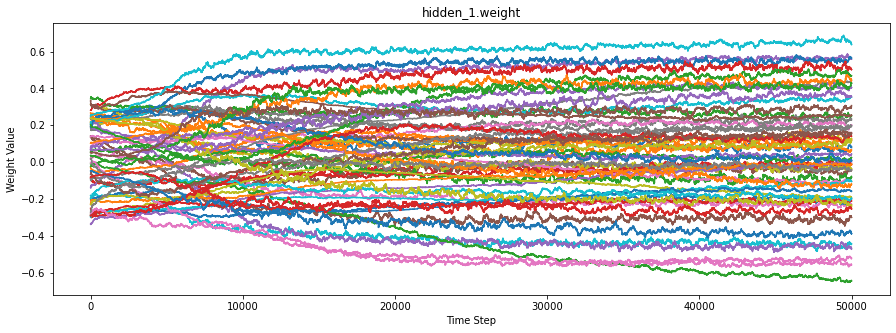

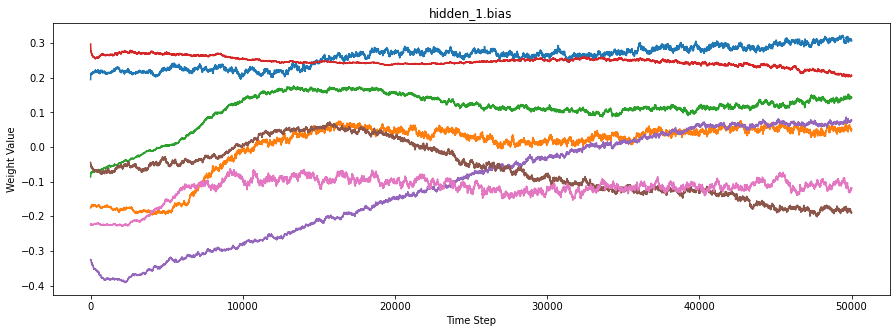

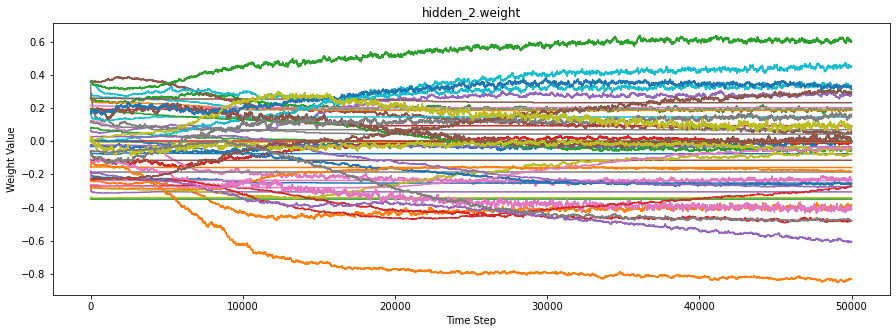

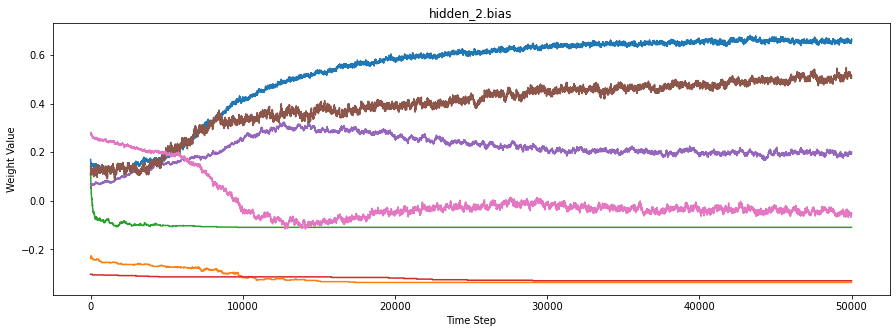

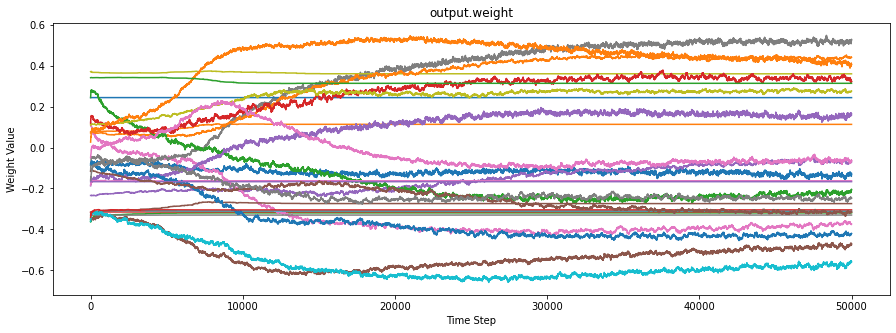

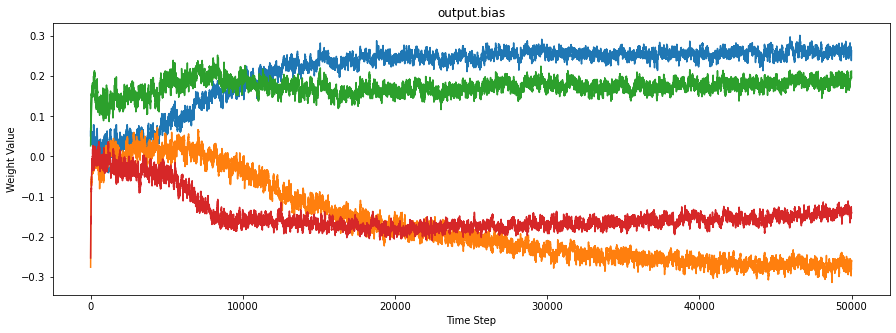

In [79]:
##x_range = (99998,100000) to view final weights
lab.graph(diff=0,graph_together = False, plot_size = (15,5) )

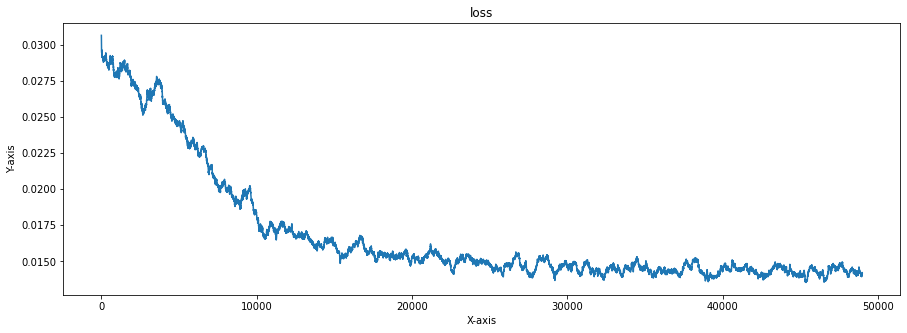

In [80]:
plot_line_graph(losses,window_size = 1000, plot_size = (15,5)) #window_size is the moving average window

56


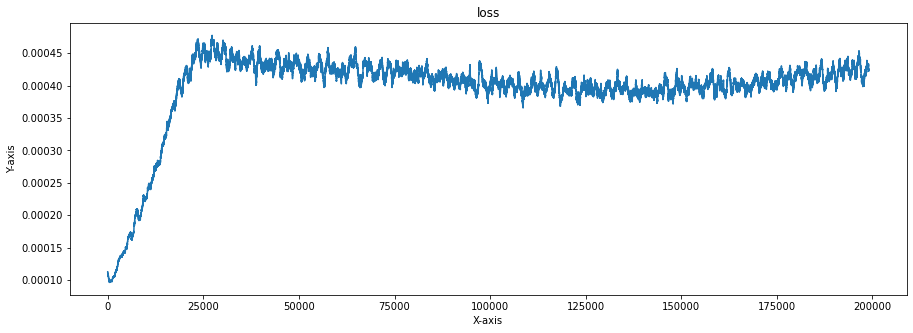

In [21]:
###These need to be graphed together, see if the layers get moved more at different epochs
##graph by neuron or by layer?
o_w = lab.LabParams['hidden_1.weight'].flatten(start_dim = 1)
print(o_w.shape[1])
o_w = o_w.detach().numpy()
o_w = np.diff(o_w, axis = 0)
o_w_ms = np.sum(np.abs(o_w), axis = 1)/o_w.shape[1]   #average absolute change in all the grad for the layer
o_w_ms_list = o_w_ms.tolist()
plot_line_graph(o_w_ms_list,window_size = 1000, plot_size = (15,5))
##This is average (per entry in weight matrix) absolute update.  window size is how far it looks back

In [ ]:
over parameterized it converges fast? strict definition of overparameterized, is it part of shape? mess with concat?

the first few samples are absolutely contingent on the initialization, the correct architecture has the lowest fluctuations in the weights, the number of parameters affects the beginning (anecdotal, more evidence) and the number or layers affects the best possible fluctuations in the tail.  

